In [78]:
import numpy as np

file_path = r"D:\bai_work_win\AngioMorph\bai_output\curve_aneurisk_aligned.npy"
file_path0 = r"D:\bai_work_win\AngioMorph\bai_output\curve_aneurisk_usable.npy"

b = np.load(file_path)

print(b.shape)
print(b)


(51, 119, 3)
[[[-3.21776454e-03 -5.25050703e-03  3.85208498e-04]
  [-7.10159959e-03 -1.09704214e-02  1.21574195e-03]
  [-1.14865216e-02 -1.69171919e-02  2.36784719e-03]
  ...
  [ 1.69610714e-01 -3.68265671e-01  2.32168530e-01]
  [ 1.69328336e-01 -3.73429926e-01  2.34786291e-01]
  [ 1.69136161e-01 -3.78140995e-01  2.37290975e-01]]

 [[ 1.94391010e-03 -7.15847918e-03  2.91191748e-02]
  [ 4.00930254e-03 -1.47007320e-02  4.22512566e-02]
  [ 6.45497334e-03 -2.28447738e-02  5.21889013e-02]
  ...
  [ 2.21617475e-01 -4.91765591e-01  2.18287537e-01]
  [ 2.01831329e-01 -5.07351559e-01  2.30247464e-01]
  [ 1.83918135e-01 -5.22221242e-01  2.39375908e-01]]

 [[ 4.34359826e-03 -3.36653424e-03 -6.59890427e-03]
  [ 4.81839985e-03 -3.71119517e-03 -7.25793224e-03]
  [ 5.04395098e-03 -3.87387743e-03 -7.56756551e-03]
  ...
  [ 2.61446215e-01 -4.36000060e-01  4.13215887e-01]
  [ 2.61673221e-01 -4.36010384e-01  4.13306907e-01]
  [ 2.61906295e-01 -4.36021192e-01  4.13400513e-01]]

 ...

 [[-1.07043998e-03 -5

In [42]:
# import numpy as np
# import vtk

# # 加载NumPy数组
# file_path = "D:\\bai_work_win\\AngioMorph\\geom_aligned_curves\\geomstats_aligned_to_frechet.npy"
# data = np.load(file_path)

# # 计算平均形状
# average_shape = np.mean(data, axis=0)

# # 创建VTK点数据和折线连接信息
# points = vtk.vtkPoints()
# polyline = vtk.vtkPolyLine()
# polyline.GetPointIds().SetNumberOfIds(average_shape.shape[0])  # 设置点的数量

# # 插入平均形状的点，并添加点到折线
# for i, point in enumerate(average_shape):
#     points.InsertNextPoint(point.tolist())
#     polyline.GetPointIds().SetId(i, i)

# # 创建包含折线的vtkCellArray
# lines = vtk.vtkCellArray()
# lines.InsertNextCell(polyline)

# # 创建vtkPolyData对象来保存点和连接信息
# poly_data = vtk.vtkPolyData()
# poly_data.SetPoints(points)
# poly_data.SetLines(lines)

# # 写入VTK文件（使用旧式的VTK文件格式）
# writer = vtk.vtkPolyDataWriter()
# output_file = "bai_output/average_shape.vtk"
# writer.SetFileName(output_file)
# writer.SetInputData(poly_data)
# writer.Write()

# print(f"形状的VTK文件已保存至: {output_file}")


形状的VTK文件已保存至: bai_output/average_shape.vtk


# Start

In [83]:
import geomstats.geometry.discrete_curves
help(geomstats.geometry.discrete_curves)

Help on module geomstats.geometry.discrete_curves in geomstats.geometry:

NAME
    geomstats.geometry.discrete_curves - Parameterized curves on any given manifold.

DESCRIPTION
    Lead author: Alice Le Brigant.

CLASSES
    geomstats.geometry.diffeo.AutodiffDiffeo(geomstats.geometry.diffeo.Diffeo)
        FTransform
    geomstats.geometry.diffeo.Diffeo(builtins.object)
        SRVTransform
    geomstats.geometry.fiber_bundle.AlignerAlgorithm(abc.ABC)
        DynamicProgrammingAligner
        IterativeHorizontalGeodesicAligner
    geomstats.geometry.fiber_bundle.FiberBundle(abc.ABC)
        SRVReparametrizationBundle
        SRVRotationBundle
        SRVRotationReparametrizationBundle
    geomstats.geometry.nfold_manifold.NFoldManifold(geomstats.geometry.manifold.Manifold)
        DiscreteCurvesStartingAtOrigin
    geomstats.geometry.nfold_manifold.NFoldMetric(geomstats.geometry.riemannian_metric.RiemannianMetric)
        L2CurvesMetric
    geomstats.geometry.pullback_metric.PullbackDi

In [43]:
# 【不动】头文件和函数定义
import sys
sys.path.append('D:\\bai_work_win\\AngioMorph\\src')

import numpy as np 
import glob
import os
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

def output_vtk_file(shape, output_file):
    # 创建VTK点数据和折线连接信息
    points = vtk.vtkPoints()
    polyline = vtk.vtkPolyLine()
    polyline.GetPointIds().SetNumberOfIds(shape.shape[0])  # 设置点的数量

    # 插入平均形状的点，并添加点到折线
    for i, point in enumerate(shape):
        points.InsertNextPoint(point.tolist())
        polyline.GetPointIds().SetId(i, i)

    # 创建包含折线的vtkCellArray
    lines = vtk.vtkCellArray()
    lines.InsertNextCell(polyline)

    # 创建vtkPolyData对象来保存点和连接信息
    poly_data = vtk.vtkPolyData()
    poly_data.SetPoints(points)
    poly_data.SetLines(lines)

    # 写入VTK文件（使用旧式的VTK文件格式）
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_file)
    writer.SetInputData(poly_data)
    writer.Write()

    print(f"形状的VTK文件已保存至: {output_file}")



def compute_centroid(curves):
    centroid = np.mean(curves, axis=0)
    return np.array(centroid)
def translate_to_centroid(curves):
    centroid = compute_centroid(curves)
    new_curves = []
    for i in range(len(curves)):
        new_curves.append(curves[i] - centroid)
    return np.array(new_curves)

def plot_curve(curve, ax=None, add_origin=True):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        curve = insert_zeros(curve, axis=-2)

    ax.plot(*[curve[:, k] for k in range(3)])
    ax.scatter(*[curve[0, k] for k in range(3)])
    return ax

def plot_geodesic(geod_points, ax=None, add_origin=True):
    n_times = geod_points.shape[0]
    k_sampling_points = geod_points.shape[-2] + 1

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)

    ax.plot(*[geod_points[0, :, k] for k in range(3)],  c="b", linewidth=2)
    ax.plot(*[geod_points[-1, :, k] for k in range(3)], c="r", linewidth=2)

    for i in range(1, n_times - 1):
        ax.plot(*[geod_points[i, :, k] for k in range(3)], c="k", linewidth=1)

    for j in range(k_sampling_points - 1):
        ax.plot(*[geod_points[:, j, k] for k in range(3)], c="k", linewidth=1)

    return ax

In [44]:
brava_files = glob.glob('brava_ica_mirrored/*.vtk')
aneurisk_files = glob.glob('aneurisk_ica_mirrored/*.vtk')
juntendo_files = glob.glob('uezono_data_mirrored/*.vtk')


resample_num=120

D:\bai_work_win\AngioMorph\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
D:\bai_work_win\AngioMorph\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


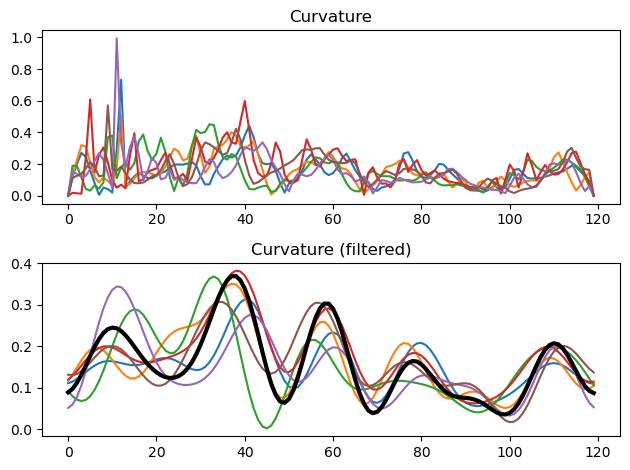

In [45]:


curvatures=[]
curves = []
freq_threshold = 0.06
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(313)


for i in range(len(juntendo_files)):
    casename = brava_files[i].split('\\')[-1].split('.')[0]
    temp = Get_simple_vtk(juntendo_files[i])
    temp = translate_to_centroid(temp)

    temp_func = parameterize_curve(temp) # 重参数化
    t_resampled = np.linspace(0, 1, resample_num) # 重采样，生成一个从 0 到 1 的均匀分布
    resampled_curve = temp_func(t_resampled) # 用重采样的 t 值生成新的曲线
    curves.append(resampled_curve)

    c, t = compute_curvature_and_torsion(resampled_curve)
    ax1.plot(c, label=casename)
    fft_c = remove_high_freq_components(c, freq_threshold ) # 傅里叶变换去高频
    rebuild = build_curve_from_curvatures(fft_c, step_length=0.1)
    ax2.plot(fft_c, label=casename)
    ax1.set_title('Curvature')
    ax2.set_title('Curvature (filtered)')
    # ax3.plot(rebuild[0], rebuild[1], label=casename)
    # print (len(c), len(fft_c))
    curvatures.append(fft_c)
curvatures = np.array(curvatures)

# np.save("unaligned_curvatures.npy", curvatures)
mean_curve = np.mean(curves, axis=0)
mean_curve_curvature, _ = compute_curvature_and_torsion(mean_curve)
mean_curve_curvature = remove_high_freq_components(mean_curve_curvature, freq_threshold)
ax2.plot(mean_curve_curvature, label='Mean',linewidth=3, color='black')
plt.tight_layout()
plt.show()


In [67]:
brava_FrechetMean = Get_simple_vtk('bai_output/brava_FrechetMean_normed.vtk')

temp_func = parameterize_curve(brava_FrechetMean) # 重参数化
t_resampled = np.linspace(0, 1, resample_num) # 重采样，生成一个从 0 到 1 的均匀分布
brava_FrechetMean = temp_func(t_resampled) # 用重采样的 t 值生成新的曲线

# 如果用现成的Brava Frechet Mean（归一化后的），就还得先这么重采样一下后再归一化做对齐reference
# 要不然 curves_r3.fiber_bundle.align（）这就报错 LinAlgError: SVD did not converge
# 但是这样以后，再输出 Brava Frechet Mean 就和最开始输入的不一样了，变长了（之前的比数据短），而且有了位移变化

# Brava Frechet Mean 的问题

In [68]:
 # 下面开始用geomstats库的工具

k_sampling_points = resample_num

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
) #初始化曲线空间
curves_r3.equip_with_metric(SRVMetric) # 配置SRV度量


curve_FrechetMean = curves_r3.projection(brava_FrechetMean)
curve_FrechetMean = curves_r3.normalize(curve_FrechetMean) # 缩放为单位长度

# output_file = "bai_output/brava_reshaped_normed_mean_curve.vtk"
# output_vtk_file(curve_a, output_file)

curve_bs = []

for i in tqdm(range(len(curves))):

    curve_b = curves_r3.projection(curves[i])
    curve_b = curves_r3.normalize(curve_b)

    if np.isnan(curve_b).any() or np.isinf(curve_b).any():
        print(f"curve {i} is invalid")
        continue

    curve_bs.append(np.array(curve_b))







100%|██████████| 6/6 [00:00<00:00, 6009.03it/s]


In [69]:
np.array(curve_bs).shape

(6, 119, 3)

In [70]:
np.array(curve_FrechetMean).shape

(119, 3)

In [71]:
curve_bs_aligned = []

for i in tqdm(range(len(curve_bs))):

    curves_r3.equip_with_group_action("rotations and reparametrizations")
    curves_r3.equip_with_quotient_structure()

    curve_b_aligned = curves_r3.fiber_bundle.align(curve_bs[i], curve_FrechetMean)
    curve_bs_aligned.append(np.array(curve_b_aligned))



curve_bs_aligned = np.array(curve_bs_aligned)




100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


In [74]:
curve_bs_aligned.shape

(6, 119, 3)

In [73]:
output_file = "bai_output/000/"
for i in range(len(curve_bs_aligned)):
    output_vtk_file(curve_bs_aligned[i], output_file + f"{i}.vtk")

形状的VTK文件已保存至: bai_output/000/0.vtk
形状的VTK文件已保存至: bai_output/000/1.vtk
形状的VTK文件已保存至: bai_output/000/2.vtk
形状的VTK文件已保存至: bai_output/000/3.vtk
形状的VTK文件已保存至: bai_output/000/4.vtk
形状的VTK文件已保存至: bai_output/000/5.vtk


In [75]:
output_file1 = "bai_output/000/aa.vtk"
output_vtk_file(curve_FrechetMean, output_file1)

形状的VTK文件已保存至: bai_output/000/aa.vtk


In [80]:
import numpy as np

# 加载已有的曲线
existing_curves_path = "geom_aligned_curves/geomstats_aligned_to_frechet.npy"
existing_curves = np.load(existing_curves_path)

for i, new_curve in enumerate(curve_bs_aligned):
    # 创建一个新的曲线集，包括所有已有的曲线和新的一条曲线
    updated_curves = np.vstack([existing_curves, new_curve[np.newaxis, :, :]])
    
    # 定义新文件的路径
    new_file_path = f"geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo{i}.npy"
    
    # 保存更新后的曲线集合
    np.save(new_file_path, updated_curves)
    print(f"Saved updated curves to {new_file_path}")


Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo0.npy
Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo1.npy
Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo2.npy
Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo3.npy
Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo4.npy
Saved updated curves to geom_aligned_curves/bai_output/geomstats_aligned_to_frechet_plus_juntendo5.npy
